# Lab Four: Wide and Deep Network Architectures


LJ Brown, Joe McGuire, Henry Warren, Mike Lefebvre, Xingming Qu


## 1. Business Understanding

In this exercise, we will 

## 2 Preparation 

### 2.1 Define and prepare your class variables

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter('ignore', DeprecationWarning)

# read original data 
 
df_orig_data = pd.read_csv('diamonds.csv')
df_orig_data.drop('Unnamed: 0',axis=1, inplace=True)
print(df_orig_data.info())
# print(df_orig_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


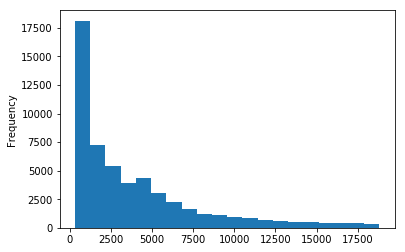

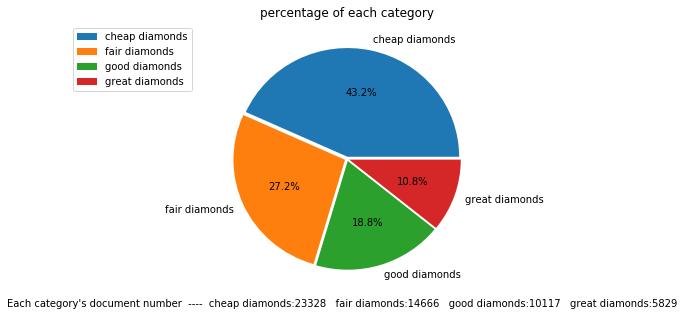

In [2]:
df_preprocessing=df_orig_data.sort_values(by='price')
plt.subplot(1,1,1)
df_preprocessing.price.plot.hist(bins=20)
max_price=df_preprocessing.price.max()

############################## Creat label for each classes ############################################ 
# 0--10%max==cheap diamonds(label 0)   10--30%max==fair diamonds(label 1)   
# 30--50%max==good diamonds(label 2)  50-100%max great diamonds(label 3)
import warnings
warnings.filterwarnings('ignore')

df_price=df_preprocessing.price
df_price[df_price<=max_price*0.10]=0
df_price[(df_price>max_price*0.10) & (df_price<=max_price*0.25)]=1
df_price[(df_price>max_price*0.25) & (df_price<=max_price*0.50)]=2
df_price[(df_price>max_price*0.50) & (df_price<=max_price*1)]=3
df_preprocessing['price']=df_price

################################# Draw a pie chart to show some infomation ################################
values=df_preprocessing['price'].value_counts()
plt.figure(figsize=(5,5))
explode=[0.02 for x in values]# Distance to center radius
name=['cheap diamonds','fair diamonds','good diamonds','great diamonds']
plt.pie(values,explode=explode,labels=name,autopct='%1.1f%%')# draw chart
plt.title('percentage of each category')#Title
plt.legend(loc='upper left', bbox_to_anchor=(-0.5, 1))
Xstring="Each category's document number  ----  "
it=0
for i in range(len(name)):
    Xstring=Xstring+name[i]+':'+str(values[i])+'   '

plt.xlabel(Xstring)
plt.show()

In [3]:
df_preprocessing.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,0,4.34,4.35,2.75


#### 2.1.1 Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [4]:
# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['cut','color','clarity']

# train all encoders (special case the target 'income')
for col in categorical_headers:
    df_preprocessing[col] = df_preprocessing[col].str.strip()

    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_preprocessing[col+'_int'] = encoders[col].fit_transform(df_preprocessing[col])


# scale the numeric, continuous variables
numeric_headers = ["carat", "depth", "table", "x", "y", "z"]

for col in numeric_headers:
    df_preprocessing[col] = df_preprocessing[col].astype(np.float)
    ss = StandardScaler()
    df_preprocessing[col] = ss.fit_transform(df_preprocessing[col].values.reshape(-1, 1))


Train/Test split 
We first used an 80/20 split to test the functionality of our network. When evaluating the algorithm’s generalized performance and tuning the hyper-parameters, we used stratified k-fold cross validation (with 10 folds) and Micro f1_score.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers

Y=df_preprocessing['price']
Y=np_utils.to_categorical(Y)
X=df_preprocessing

df_train, df_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)



Using TensorFlow backend.


#### 2.1.2 One Hot Encoding Categorical Data

In [6]:
# but we were dealing with the data incorrectly because we didn't one hot encode the 
#   categorical features
from sklearn.preprocessing import OneHotEncoder

def makeOneHot(Xtrain,Xtest,headers):
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(Xtrain[headers].values)
    X_test_ohe = ohe.transform(Xtest[headers].values)
    
    return X_train_ohe,X_test_ohe


X_train_ohe, X_test_ohe=makeOneHot(df_train,df_test,categorical_headers_ints)

### 2.2 Making Crossed Columns

color and clarity should be crossed because...
the implementation will be done in the modeling section

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import concatenate
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import metrics as mt
from keras import metrics

## 3 Modeling 
### 3.1 Create several(two) combined wide and deep networks to classify your data using Keras.

#### 3.1.1 Step One: Using Dense embeddings

In [8]:
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=4,activation='softmax', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

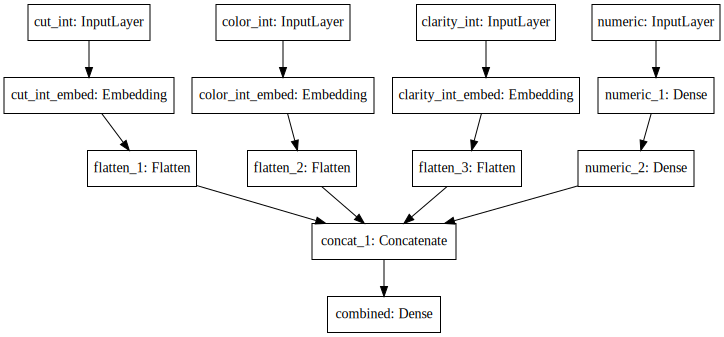

In [9]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_num], # create a list of inputs for embeddings
        y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
43152/43152 [==============================] - 2s 47us/step - loss: 0.4377 - acc: 0.8339
Epoch 2/5
43152/43152 [==============================] - 2s 39us/step - loss: 0.2388 - acc: 0.9091
Epoch 3/5
43152/43152 [==============================] - 2s 36us/step - loss: 0.1981 - acc: 0.9235
Epoch 4/5
43152/43152 [==============================] - 2s 37us/step - loss: 0.1825 - acc: 0.9293
Epoch 5/5
43152/43152 [==============================] - 2s 37us/step - loss: 0.1741 - acc: 0.9315
Wall time: 8.87 s


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
# print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))
f1_score(y_test,yhat,average='micro')

0.9232480533926585

#### 3.1.2 Step Two: Making Crossed Columns

In [12]:


cross_columns = [['cut','color'],
                 ['color', 'clarity'],
                 [ 'clarity','cut']
                 ]

# we will create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    
    # 3. save encodings in a list for each branch
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories in the crossing
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the crossed encoding
    inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
    all_inputs.append(inputs) # save this as input for the keras.Model
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name='_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x) # save for concatenating later
    
# merge the branches together
final_branch = concatenate(all_branch_outputs)
# add a layer after merging
final_branch = Dense(units=4,activation='softmax',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

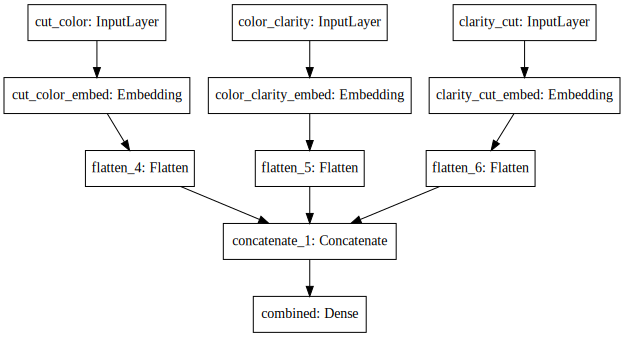

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_ints_train,
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
43152/43152 [==============================] - 2s 37us/step - loss: 1.2113 - acc: 0.4803
Epoch 2/10
43152/43152 [==============================] - 1s 32us/step - loss: 1.1762 - acc: 0.4899
Epoch 3/10
43152/43152 [==============================] - 1s 31us/step - loss: 1.1732 - acc: 0.4904
Epoch 4/10
43152/43152 [==============================] - 1s 30us/step - loss: 1.1722 - acc: 0.4897
Epoch 5/10
43152/43152 [==============================] - 1s 32us/step - loss: 1.1716 - acc: 0.4899
Epoch 6/10
43152/43152 [==============================] - 1s 31us/step - loss: 1.1714 - acc: 0.4895
Epoch 7/10
43152/43152 [==============================] - 1s 31us/step - loss: 1.1712 - acc: 0.4905
Epoch 8/10
43152/43152 [==============================] - 1s 31us/step - loss: 1.1710 - acc: 0.4887
Epoch 9/10
43152/43152 [==============================] - 1s 32us/step - loss: 1.1710 - acc: 0.4905
Epoch 10/10
43152/43152 [==============================] - 1s 30us/step - loss: 1.1709 - acc: 0.4887

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
yhat = np.round(model.predict(X_ints_test))
# print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))
f1_score(y_test,yhat,average='micro')

0.3559611344537815

#### 3.1.3 Step Three (Final): Combining Crossed Linear Classifier and Deep Embeddings

Using one wide and deep networks to classify

In [16]:

embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=4,activation='softmax',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)



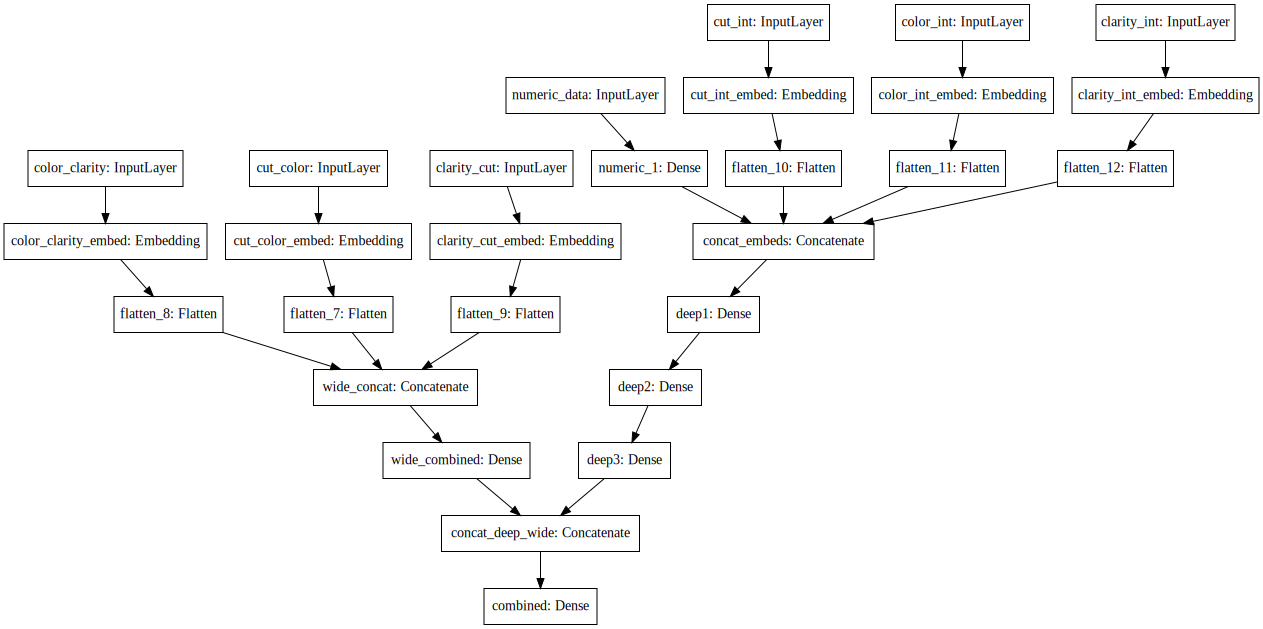

In [17]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [18]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 43152 samples, validate on 10788 samples
Epoch 1/10
43152/43152 [==============================] - 3s 75us/step - loss: 0.2889 - acc: 0.8864 - val_loss: 0.1681 - val_acc: 0.9333
Epoch 2/10
43152/43152 [==============================] - 2s 57us/step - loss: 0.1737 - acc: 0.9309 - val_loss: 0.1734 - val_acc: 0.9297
Epoch 3/10
43152/43152 [==============================] - 2s 54us/step - loss: 0.1657 - acc: 0.9337 - val_loss: 0.1563 - val_acc: 0.9396
Epoch 4/10
43152/43152 [==============================] - 2s 57us/step - loss: 0.1612 - acc: 0.9359 - val_loss: 0.1601 - val_acc: 0.9343
Epoch 5/10
43152/43152 [==============================] - 2s 55us/step - loss: 0.1590 - acc: 0.9362 - val_loss: 0.1578 - val_acc: 0.9362
Epoch 6/10
43152/43152 [==============================] - 2s 56us/step - loss: 0.1565 - acc: 0.9372 - val_loss: 0.1520 - val_acc: 0.9396
Epoch 7/10
43152/43152 [==============================] - 2s 56us/step - loss: 0.1539 - acc: 0.9387 - val_loss: 0.1546 - val_acc

Using two wide and deep networks to classify

In [19]:
def creatCombinedModel(df_train,df_test):
# we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    wide_branch2 = concatenate(all_wide_branch_outputs, name='wide_concat-2')
    wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined-2')(wide_branch2)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    # deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds-2')
    deep_branch2 = Dense(units=60,activation='relu', name='deep1-2')(deep_branch2)
    deep_branch2 = Dense(units=30,activation='relu', name='deep2-2')(deep_branch2)


    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide1')


    final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide2')


    final_branch3 = concatenate([final_branch1, final_branch2],name='concat_deep_wide_final')
    final_branch3= Dense(units=4,activation='softmax',name='combined-final')(final_branch3)

    model2 = Model(inputs=all_inputs, outputs=final_branch3)
    return model2,X_ints_train,X_ints_test



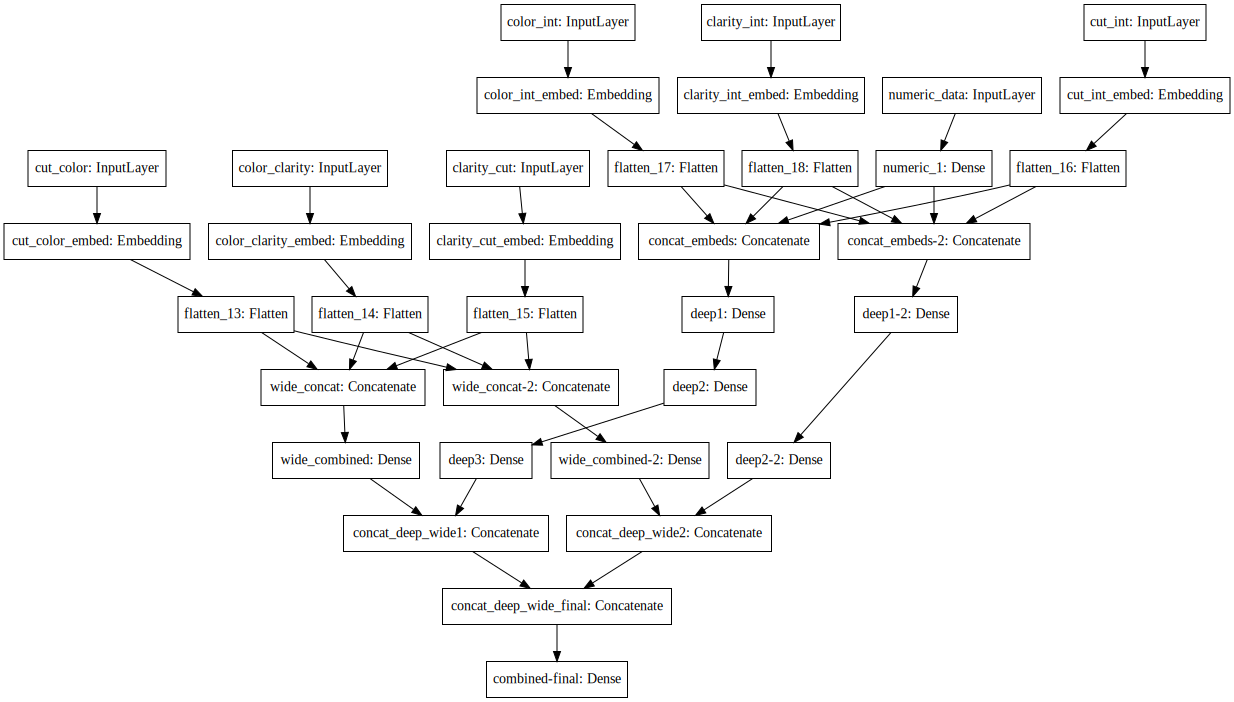

In [20]:
model2,_,_=creatCombinedModel(df_train,df_test)
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [21]:
%%time

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history_two_combine = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 43152 samples, validate on 10788 samples
Epoch 1/10
43152/43152 [==============================] - 4s 81us/step - loss: 0.1495 - acc: 0.9407 - val_loss: 0.1488 - val_acc: 0.9400
Epoch 2/10
43152/43152 [==============================] - 3s 60us/step - loss: 0.1486 - acc: 0.9412 - val_loss: 0.1516 - val_acc: 0.9372
Epoch 3/10
43152/43152 [==============================] - 3s 60us/step - loss: 0.1476 - acc: 0.9409 - val_loss: 0.1507 - val_acc: 0.9390
Epoch 4/10
43152/43152 [==============================] - 3s 58us/step - loss: 0.1458 - acc: 0.9416 - val_loss: 0.1474 - val_acc: 0.9410
Epoch 5/10
43152/43152 [==============================] - 2s 55us/step - loss: 0.1455 - acc: 0.9414 - val_loss: 0.1540 - val_acc: 0.9375
Epoch 6/10
43152/43152 [==============================] - 2s 56us/step - loss: 0.1460 - acc: 0.9411 - val_loss: 0.1479 - val_acc: 0.9397
Epoch 7/10
43152/43152 [==============================] - 2s 56us/step - loss: 0.1450 - acc: 0.9416 - val_loss: 0.1470 - val_acc

Visualize the performance of the network on the training data and validation data in the same plot versus the training 

Text(0.5,0,'epochs')

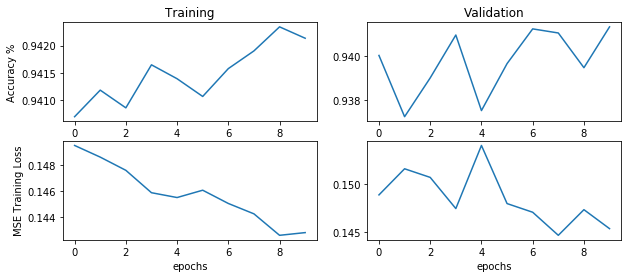

In [22]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_two_combine.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_two_combine.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_two_combine.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_two_combine.history['val_loss'])
plt.xlabel('epochs')

### 3.2Investigate generalization performance by altering the number of layers in the deep branch of the network.

In [23]:
##################################### First model###########################################
# number of layers in the deep branch of the network.
# first network (40 20 10)    second(60 30 15)


def creatCombinedModelFirst(df_train,df_test):
# we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    wide_branch2 = concatenate(all_wide_branch_outputs, name='wide_concat-2')
    wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined-2')(wide_branch2)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=40,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    # deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds-2')
    deep_branch2 = Dense(units=60,activation='relu', name='deep1-2')(deep_branch2)
    deep_branch2 = Dense(units=30,activation='relu', name='deep2-2')(deep_branch2)
#     deep_branch2 = Dense(units=15,activation='relu', name='deep2-3')(deep_branch2)


    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide1')


    final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide2')


    final_branch3 = concatenate([final_branch1, final_branch2],name='concat_deep_wide_final')
    final_branch3= Dense(units=4,activation='softmax',name='combined-final')(final_branch3)

    model2 = Model(inputs=all_inputs, outputs=final_branch3)
    return model2,X_ints_train,X_ints_test



In [24]:
##################################### Second model###########################################
# number of layers in the deep branch of the network.
# first network (40 20 )    second(60 30)


def creatCombinedModelSecond(df_train,df_test):
# we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    wide_branch2 = concatenate(all_wide_branch_outputs, name='wide_concat-2')
    wide_branch2 = Dense(units=1,activation='sigmoid',name='wide_combined-2')(wide_branch2)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=40,activation='relu', name='deep1')(deep_branch)
#     deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
#     deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    # deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds-2')
    deep_branch2 = Dense(units=60,activation='relu', name='deep1-2')(deep_branch2)
#     deep_branch2 = Dense(units=30,activation='relu', name='deep2-2')(deep_branch2)


    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide1')


    final_branch2 = concatenate([wide_branch2, deep_branch2],name='concat_deep_wide2')


    final_branch3 = concatenate([final_branch1, final_branch2],name='concat_deep_wide_final')
    final_branch3= Dense(units=4,activation='softmax',name='combined-final')(final_branch3)

    model2 = Model(inputs=all_inputs, outputs=final_branch3)
    return model2,X_ints_train,X_ints_test



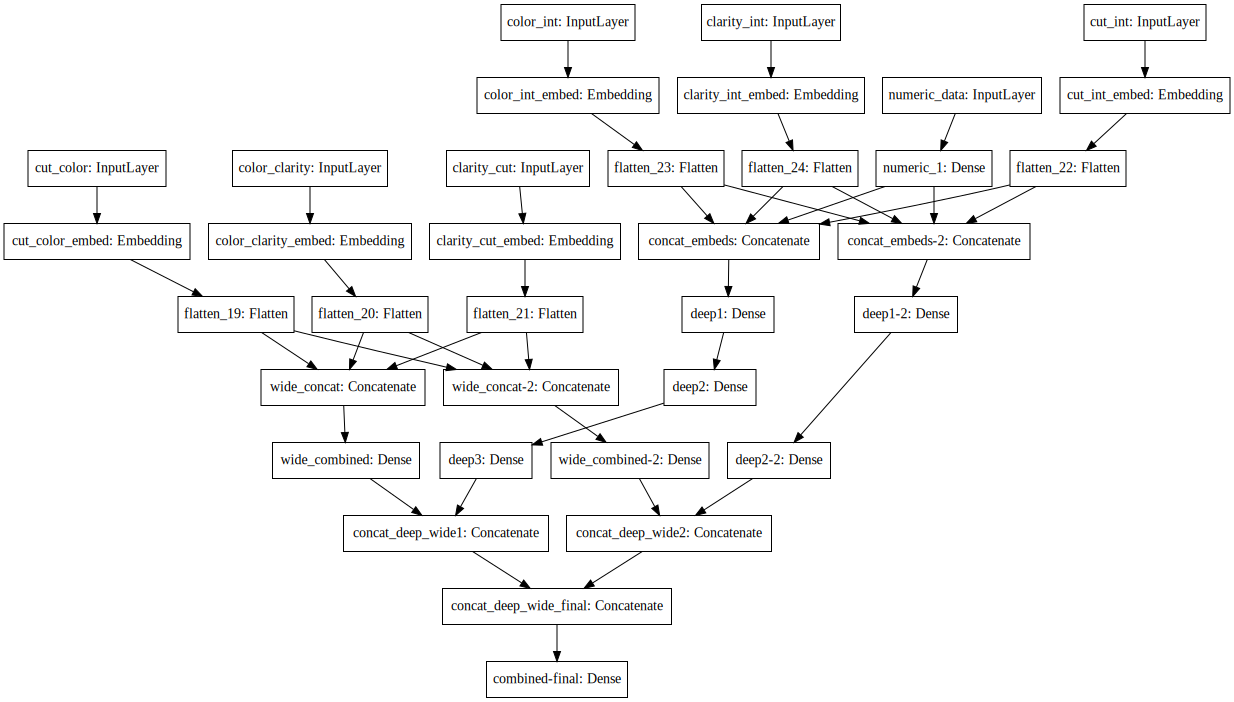

In [25]:
modelfirst,_,_=creatCombinedModelFirst(df_train,df_test)
SVG(model_to_dot(modelfirst).create(prog='dot', format='svg'))



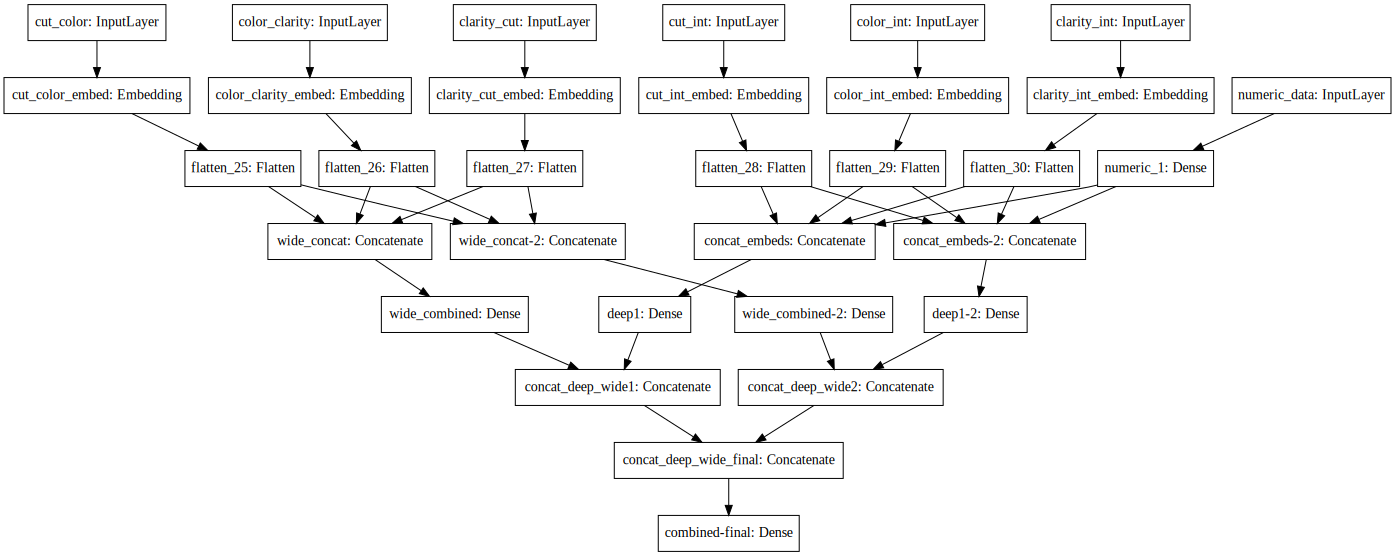

In [26]:
modelsecond,_,_=creatCombinedModelSecond(df_train,df_test)
SVG(model_to_dot(modelsecond).create(prog='dot', format='svg'))

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
K_fold=5
def ourStratifiedKFold(num):
    cv = StratifiedShuffleSplit(n_splits=K_fold,test_size=0.2)
    fold=cv.split(X,Y)
    X_train_Stratified = []
    X_test_Stratified = []
    y_train_Stratified = []
    y_test_Stratified = []

    X_train_Stratified_num=[]
    X_test_Stratified_num=[]

    for train_index, test_index in fold:
        X_train_Stratified.append(X.iloc[train_index])
        X_test_Stratified.append(X.iloc[test_index])
        y_train_Stratified.append(Y[train_index])
        y_test_Stratified.append(Y[test_index])

        X_train_Stratified_num.append(X_train_Stratified[-1][numeric_headers])
        X_test_Stratified_num.append(X_test_Stratified[-1][numeric_headers])

    score=[]
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    plt.figure()

    for i in range(len(X_train_Stratified)):
        print('fold',i)

        if num==1:
            model,X_ints_train,X_ints_test = creatCombinedModelFirst(X_train_Stratified[i],X_test_Stratified[i])
        if num==2:
            model,X_ints_train,X_ints_test = creatCombinedModelSecond(X_train_Stratified[i],X_test_Stratified[i])
            
        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress
        history=model.fit(X_ints_train+ [X_train_Stratified_num[i]],
                        y_train_Stratified[i], 
                        epochs=5, 
                        batch_size=32, 
                        verbose=0, 
                          )

        yhat =np.round(model.predict(X_ints_test+ [X_test_Stratified_num[i]]))
        score.append(f1_score(y_test_Stratified[i],yhat,average='micro'))
        

        y_score =yhat
        y_test=y_test_Stratified[i]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(4):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



        plt.plot(fpr[2], tpr[2],
                 lw=1, label='fold %d ROC curve (area = %0.2f)' % (i+1,roc_auc[2]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
    plt.show()
    return score,np.mean(score)
    

fold 0
fold 1
fold 2
fold 3
fold 4


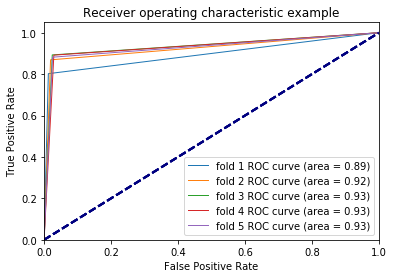

Wall time: 1min 29s


In [28]:
%%time

first_score,first_mean=ourStratifiedKFold(1)

fold 0
fold 1
fold 2
fold 3
fold 4


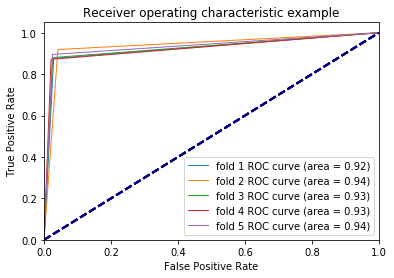

In [29]:
second_score,second_mean=ourStratifiedKFold(2)

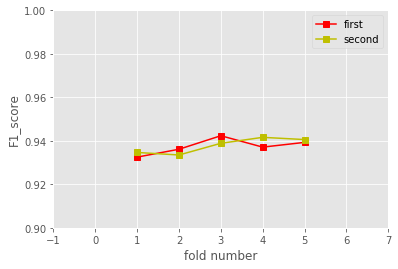

mean f1 of first: 0.9374726820263508
mean f1 of second: 0.9378359224084829


In [30]:
plt.style.use('ggplot')
length=range(1,K_fold+1)
plt.plot(length,first_score,'s-',color = 'r',label="first")
plt.plot(length,second_score,'s-',color = 'y',label="second")

plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0.9, 1)
plt.xlim(-1, K_fold+2)
plt.show()
print('mean f1 of first:',first_mean)
print('mean f1 of second:',second_mean)


### 3.3 ompare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP).


fold 0
fold 1
fold 2
fold 3
fold 4


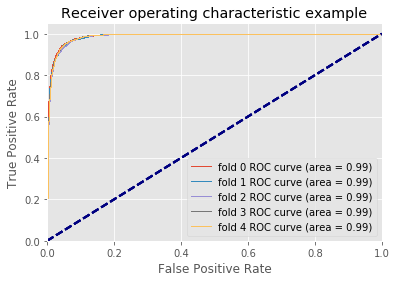

Wall time: 9.29 s


In [31]:
%%time


category=['cut_int','color_int','clarity_int']
cv = StratifiedShuffleSplit(n_splits=K_fold,test_size=0.2)
fold=cv.split(X,Y)
X_train_Stratified = []
X_test_Stratified = []
y_train_Stratified = []
y_test_Stratified = []

X_train_Stratified_num=[]
X_test_Stratified_num=[]

for train_index, test_index in fold:
    X_train_Stratified.append(X.iloc[train_index])
    X_test_Stratified.append(X.iloc[test_index])
    y_train_Stratified.append(Y[train_index])
    y_test_Stratified.append(Y[test_index])

    X_train_Stratified_num.append(X_train_Stratified[-1][numeric_headers])
    X_test_Stratified_num.append(X_test_Stratified[-1][numeric_headers])
    

mlp_score=[]
#using one hot encoding for category data and plus numeric as feature
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
plt.figure()
for i in range(len(X_train_Stratified)):
    print('fold',i)
    X_train_ohe, X_test_ohe=makeOneHot(X_train_Stratified[i],X_test_Stratified[i],category)
    
    X_train=np.hstack((X_train_ohe.toarray(),  X_train_Stratified_num[i].values))
    X_test=np.hstack((X_test_ohe.toarray(),  X_test_Stratified_num[i].values))
    
    clf = MLPClassifier(hidden_layer_sizes=(60,30,15),max_iter=5)
    clf.fit(X_train,y_train_Stratified[i])
    
    yhat = clf.predict(X_test)
    mlp_score.append(f1_score(y_test_Stratified[i],yhat,average='micro'))
    
    
    y_score =clf.predict_proba(X_test)
    y_test=y_test_Stratified[i]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(4):
        fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    
    
    plt.plot(fpr[2], tpr[2],
             lw=1, label='fold %d ROC curve (area = %0.2f)' % (i,roc_auc[2]))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
plt.show()

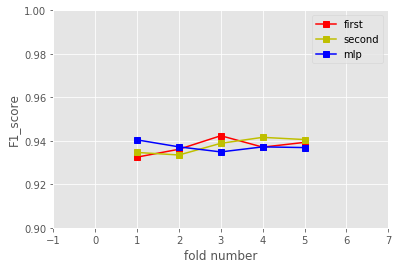

mean f1 of first: 0.9374726820263508
mean f1 of second: 0.9378359224084829
mean f1 of mlp: 0.9373321353859039


In [32]:
plt.style.use('ggplot')
length=range(1,K_fold+1)
plt.plot(length,first_score,'s-',color = 'r',label="first")
plt.plot(length,second_score,'s-',color = 'y',label="second")
plt.plot(length,mlp_score,'s-',color = 'b',label="mlp")

plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0.9, 1)
plt.xlim(-1, K_fold+2)
plt.show()
print('mean f1 of first:',first_mean)
print('mean f1 of second:',second_mean)
print('mean f1 of mlp:',np.mean(mlp_score))
